<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using GPT text embedding and CLIP image embedding for Wikipedia Articles

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Wikipedia Text embedding index: Generate GPT text embeddings from OpenAI for texts

Wikipedia Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using GPT embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores

In [ ]:
%pip install -q llama-index-vector-stores-qdrant

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rhr9aa0a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rhr9aa0a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install llama-index-embeddings-clip

## Load and Download Multi-Modal datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

In [ ]:
pwd

'/content'

In [ ]:
from pathlib import Path
import requests

wiki_titles = [
    "RoboCop",
    "Labour Party (UK)",
    "SpaceX",
    "OpenAI",
]


data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

## Parse Wikipedia Images and texts. Load into local folder

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=1baa5a995aade1d26407d53a1a1c080c5c960a39d3eec38dc159f8757a31e28d
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [ ]:
import wikipedia
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "RoboCop",
    "Labour Party (UK)",
    "SpaceX",
    "OpenAI",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

RoboCop
Labour Party (UK)
No images found for Wikipedia page: Labour Party (UK)
SpaceX
No images found for Wikipedia page: SpaceX
OpenAI
No images found for Wikipedia page: OpenAI


In [ ]:
import os

from google.colab import userdata

os.environ["OPENAI_API_KEY"] = "Your API Key"


## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [ ]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_d_0")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection_0"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection_0"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 140MiB/s]
/usr/local/lib/python3.11/dist-packages/llama_index/vector_stores/qdrant/base.py:644: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


### Plot downloaded Images from Wikipedia

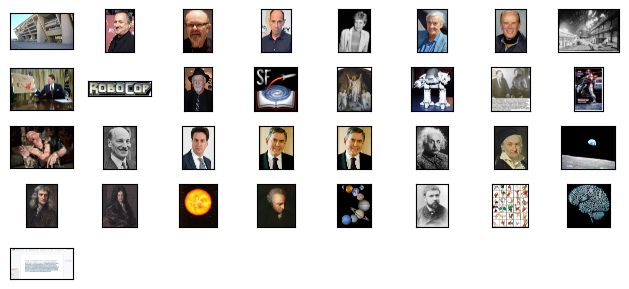

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_metadata_dict):
    original_images_urls = []
    images_shown = 0
    for image_id in image_metadata_dict:
        img_path = image_metadata_dict[image_id]["img_path"]
        if os.path.isfile(img_path):
            filename = image_metadata_dict[image_id]["filename"]
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, len(original_images_urls) + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            original_images_urls.append(filename)
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()


plot_images(image_metadata_dict)

### Build a separate CLIP image embedding index under a differnt collection `wikipedia_img`

In [ ]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

## Get Multi-Modal retrieval results for some example queries

In [ ]:
test_query = "what is the Labour Party?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

In [ ]:
retrieval_results

[NodeWithScore(node=TextNode(id_='cfde956c-205c-44f3-8eb2-a3c69ee22585', embedding=None, metadata={'file_path': '/content/data_wiki/Labour Party (UK).txt', 'file_name': 'Labour Party (UK).txt', 'file_type': 'text/plain', 'file_size': 50094, 'creation_date': '2025-02-13', 'last_modified_date': '2025-02-13'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='97f8e516-5a21-41ec-95b7-991d5f59b798', node_type='4', metadata={'file_path': '/content/data_wiki/Labour Party (UK).txt', 'file_name': 'Labour Party (UK).txt', 'file_type': 'text/plain', 'file_size': 50094, 'creation_date': '2025-02-13', 'last_modified_date': '2025-02-13'}, hash='4dcd642e0061dc8d7b422cd7ceaaddb1f67988ff53f9cb0e9efcd311c067f232'), <NodeRelati

**Node ID:** cfde956c-205c-44f3-8eb2-a3c69ee22585<br>**Similarity:** 0.8924335829052241<br>**Text:** The Labour Party is a political party in the United Kingdom that sits on the centre-left of the political spectrum. The party has been described as an alliance of social democrats, democratic socia...<br>

**Node ID:** d9d97ed8-6b69-42fb-975f-cca9e651d39a<br>**Similarity:** 0.8758801217804019<br>**Text:** == Constitution and structure ==

The Labour Party is a membership organisation consisting of individual members and constituency Labour parties, affiliated trade unions, socialist societies and th...<br>

**Node ID:** ecf4feea-82fa-474d-9c87-200f0dededfa<br>**Similarity:** 0.8713339934514398<br>**Text:** === Trade union link ===

The Trade Union and Labour Party Liaison Organisation is the co-ordinating structure that supports the policy and campaign activities of affiliated union members within th...<br>

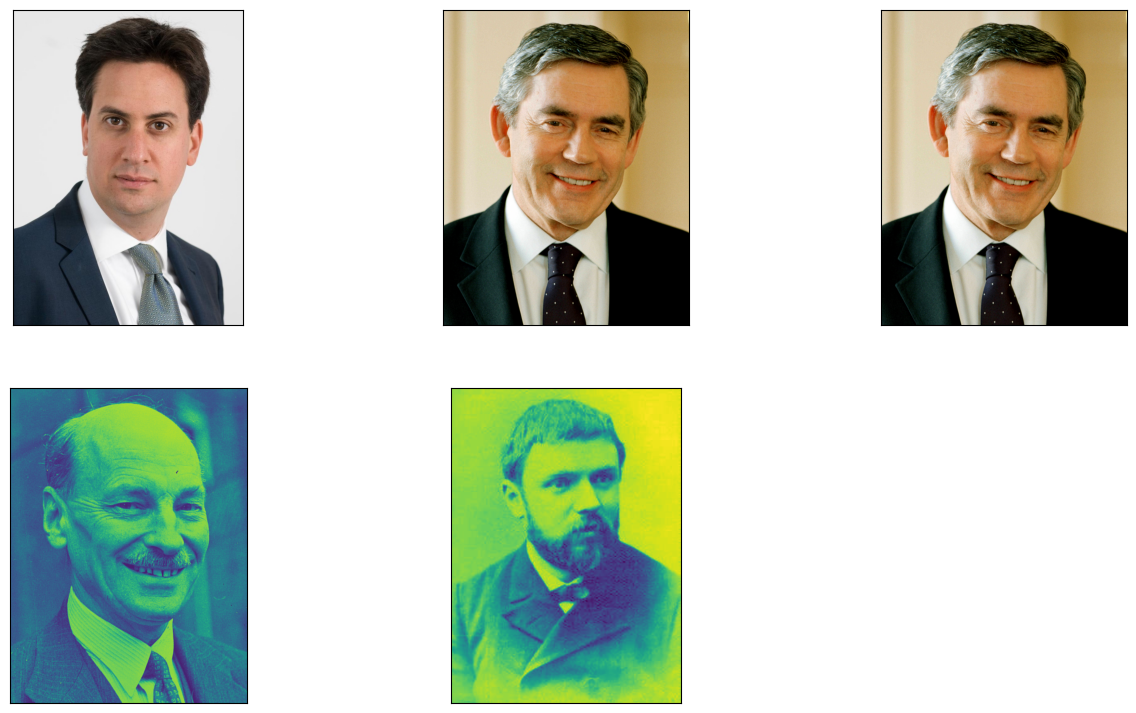

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 7a05863b-8cad-4bb4-b5e3-ef83083eed77<br>**Similarity:** 0.872710584047262<br>**Text:** RoboCop is a 1987 American science fiction action film directed by Paul Verhoeven and written by Edward Neumeier and Michael Miner. The film stars Peter Weller, Nancy Allen, Daniel O'Herlihy, Ronny...<br>

**Node ID:** ad972bd5-59df-477b-887b-18ff27eed07c<br>**Similarity:** 0.8694838020723704<br>**Text:** === Development ===

The first draft of the script, RoboCop: The Future of Law Enforcement, was given to industry friends and associates in early 1985. A month later, Neumeier and Miner had two off...<br>

**Node ID:** a40f726d-b19c-443b-ba58-a96a021dbd70<br>**Similarity:** 0.86465411654761<br>**Text:** == Cast ==

Peter Weller as Alex Murphy / RoboCop: A Detroit police officer murdered in the line of duty and revived as a cyborg
Nancy Allen as Anne Lewis: A tough and loyal police officer
Daniel O...<br>

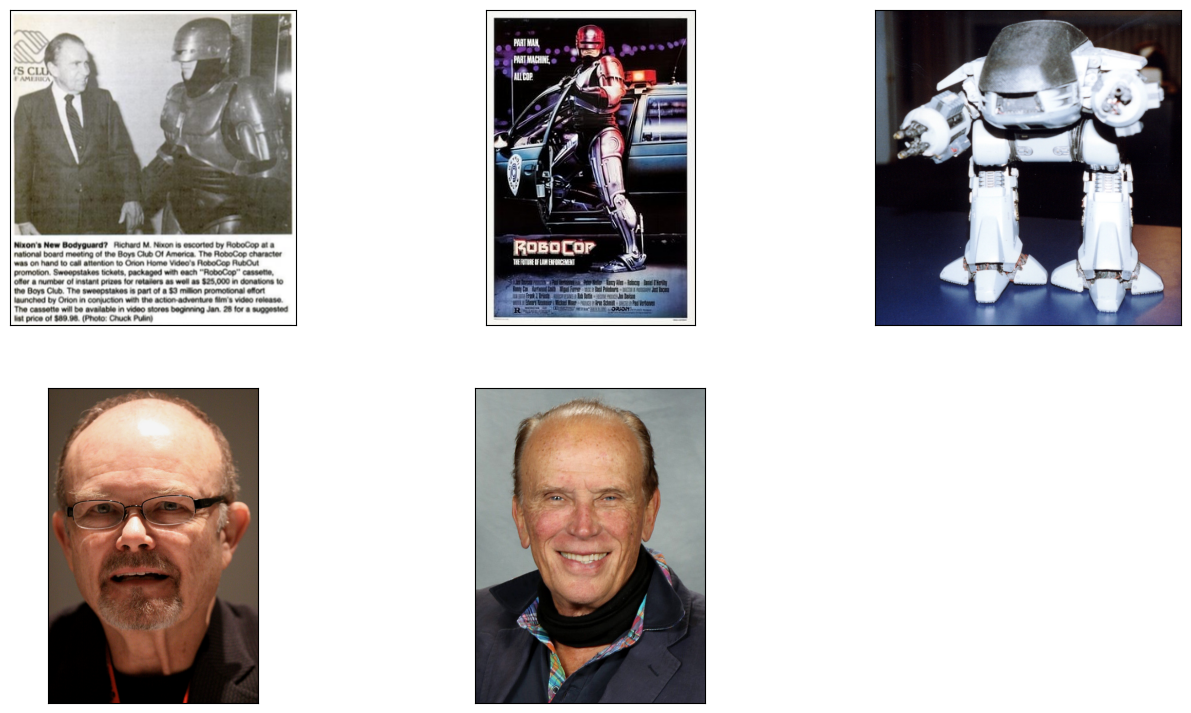

In [ ]:
test_query = "Who created RoboCop?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 01edb4b4-baf7-4d52-bbb6-2ebeff569461<br>**Similarity:** 0.8687434107794991<br>**Text:** == Products and applications ==


=== Reinforcement learning ===
At its beginning, OpenAI's research included many projects focused on reinforcement learning (RL). OpenAI has been viewed as an impo...<br>

**Node ID:** 978a630a-085a-404f-b487-504758030623<br>**Similarity:** 0.8605133868953452<br>**Text:** OpenAI, Inc. is an American artificial intelligence (AI) research organization founded in December 2015 and headquartered in San Francisco, California. It aims to develop "safe and beneficial" arti...<br>

**Node ID:** 34865916-f081-4477-bf39-6ed7f2e41f73<br>**Similarity:** 0.8598410289771354<br>**Text:** A group of nine current and former OpenAI employees has accused the company of prioritizing profits over safety, using restrictive agreements to silence concerns, and moving too quickly with inadeq...<br>

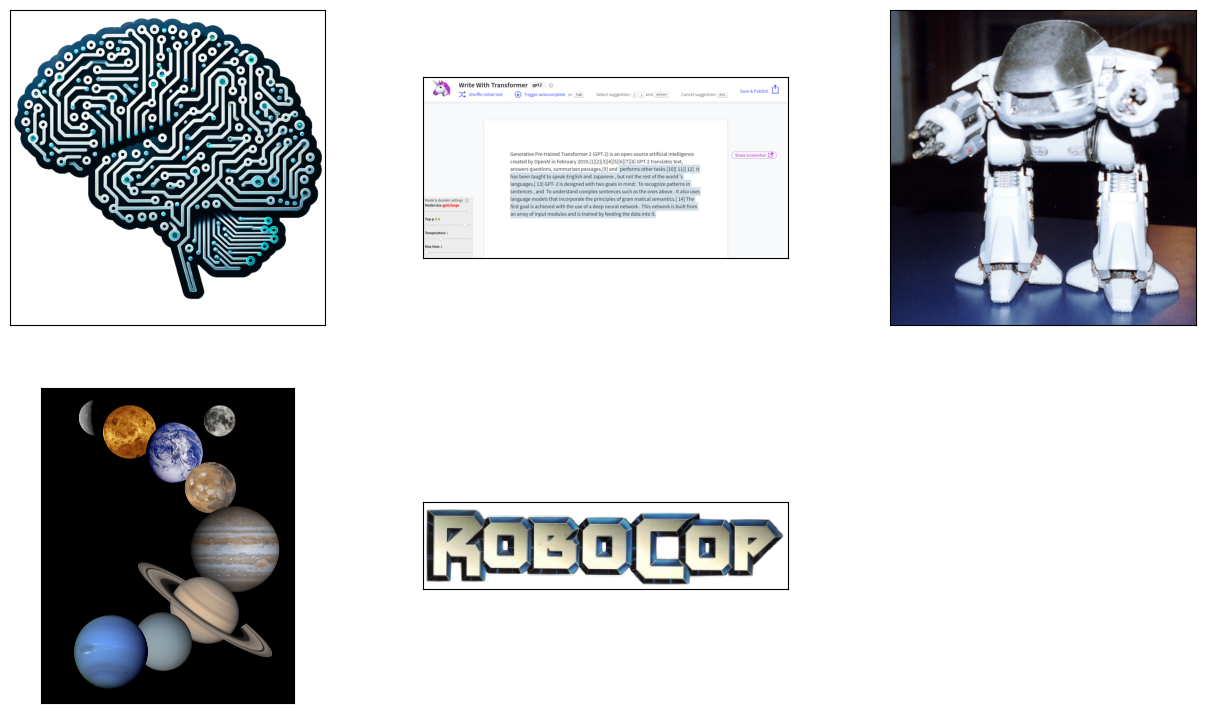

In [ ]:
test_query = "What does OpenAI do?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 2befc1fb-f426-48a3-89d1-e8c19e85cf47<br>**Similarity:** 0.7835036880762385<br>**Text:** Space Exploration Technologies Corporation, commonly referred to as SpaceX, is an American spacecraft manufacturer, launch service provider and satellite communications company headquartered in Haw...<br>

**Node ID:** b27cbf6b-8656-413e-9980-53f30f28c8af<br>**Similarity:** 0.7632136589896332<br>**Text:** === Autonomous spaceport drone ships ===

SpaceX routinely returns the first stage of Falcon 9 and Falcon Heavy rockets after orbital launches. The rocket lands at a predetermined landing site usin...<br>

**Node ID:** 7a0ad871-f174-4dca-947c-3dc823f3af36<br>**Similarity:** 0.7574105670281253<br>**Text:** == Facilities ==
SpaceX is headquartered in Hawthorne, California, which also serves as its primary manufacturing plant. The company operates a research and major operation in Redmond, Washington, ...<br>

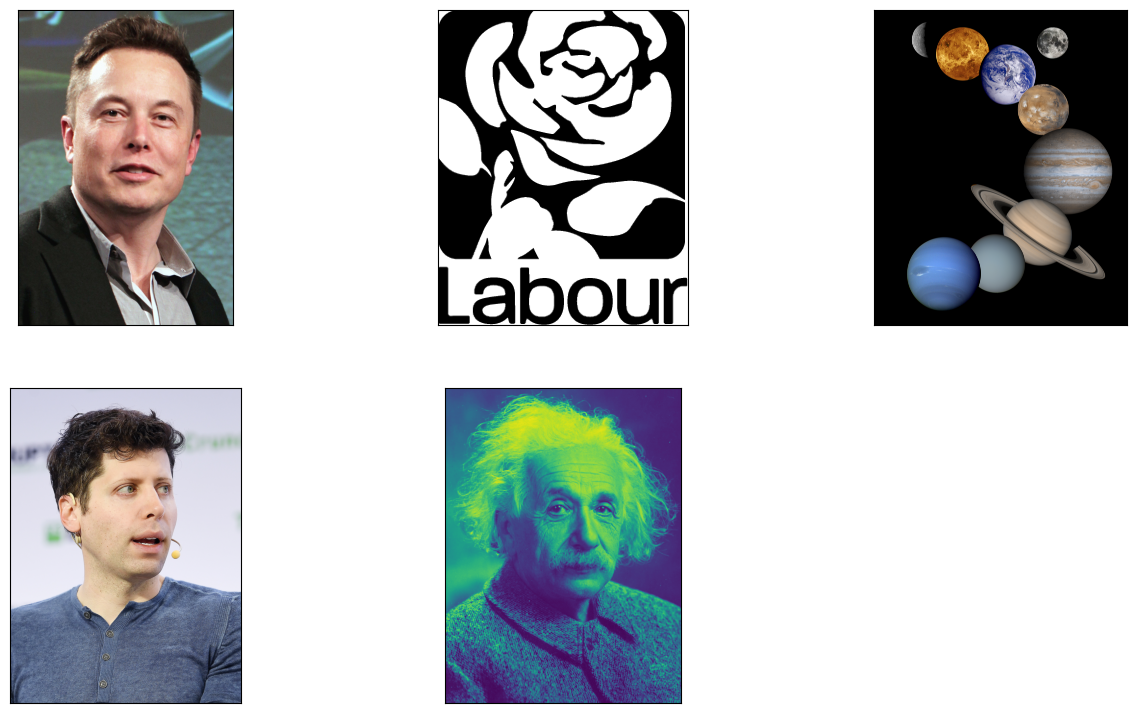

In [ ]:
test_query = "which company makes Tesla"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)